The game of life is simple 2D cellular automata. Cells can be on or off. The current state depends only on the preceding one. The fate of a given cell depends only on the number of its next nearest neighbors NN as follows:

A cell dies if NN = 0,1,4,5,6,7,8.

A cell survives if NN = 2,3.

A dead cell comes to life if NN = 3.

i explore several implementations and compare their performance


In [1]:

# -*- coding: utf-8 -*-
"""
Created on Wed Dec 26 18:34:47 2021

@author: Lyth Mashni
"""
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.sparse import dia_matrix
from PIL import Image
from matplotlib import animation, rc
from IPython.display import HTML

We first set up the playing field. Below are a few arrays as an initial state, along with a function to embed them into a larger array.

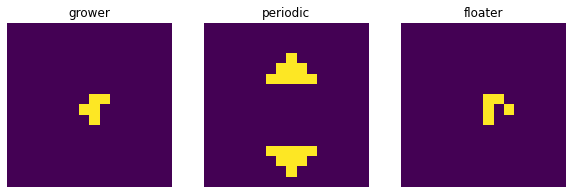

In [2]:


grower = np.array(
        [ [0,0,0,0,0],
          [0,0,1,1,0],
          [0,1,1,0,0],
          [0,0,1,0,0],
          [0,0,0,0,0]]
        ) 

periodic = np.array(
        [ [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,1,0,0,0,0,0],
          [0,0,0,0,1,1,1,0,0,0,0],
          [0,0,0,1,1,1,1,1,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,1,1,1,1,1,0,0,0],
          [0,0,0,0,1,1,1,0,0,0,0],
          [0,0,0,0,0,1,0,0,0,0,0]]
        )

floater = np.array(
        [ [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,1,1,0,0,0,0],
          [0,0,0,0,0,1,0,1,0,0,0],
          [0,0,0,0,0,1,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0]]
        )

def emb_mat(Z,d):
    d2=int(d/2)
    y = np.zeros((d,d))
    a,b = int(Z.shape[0]/2),int(Z.shape[1]/2)
    a1 ,a2 = int(np.floor(Z.shape[0]/2)) , int(np.ceil(Z.shape[0]/2))
    b1 ,b2 = int(np.floor(Z.shape[1]/2)) , int(np.ceil(Z.shape[1]/2))
    y[d2-a1:d2+a2,d2-b1:d2+b2]= Z
    
    return y

plt.rcParams["figure.figsize"] = (10,10)

names=['grower','periodic','floater']
mats = [grower,periodic,floater]
fig ,ax = plt.subplots(1,3)
for i,z,n in zip(range(3),mats,names):
    ax[i].imshow(emb_mat(z,16))
    ax[i].axis('off')
    ax[i].set_title(n)

Depending on the initial condition, the game dies out, behaves periodically or grows beyond all bounds. The initial conditions illustrated above give an example of each situation. We proceed with the first one, though we encourage you to later try out the other ones by changing the input of the function in the next field or inputting your own.

We now need a function to count the number of neighbors of each cell. For this we use the numpy.roll function which shifts an array along a given axis for a given number of steps. Since the function pushes the last element to the first position this gives us periodic boundary conditions. We now simply shift our array once in each of the eight directions and add the results up. This returns an array with the number of neighbors at each point. Since this is the computationally expensive part I will later explore two more methods of counting the neighbors where I employ convolution theory and sparse matrix multiplication respectively.

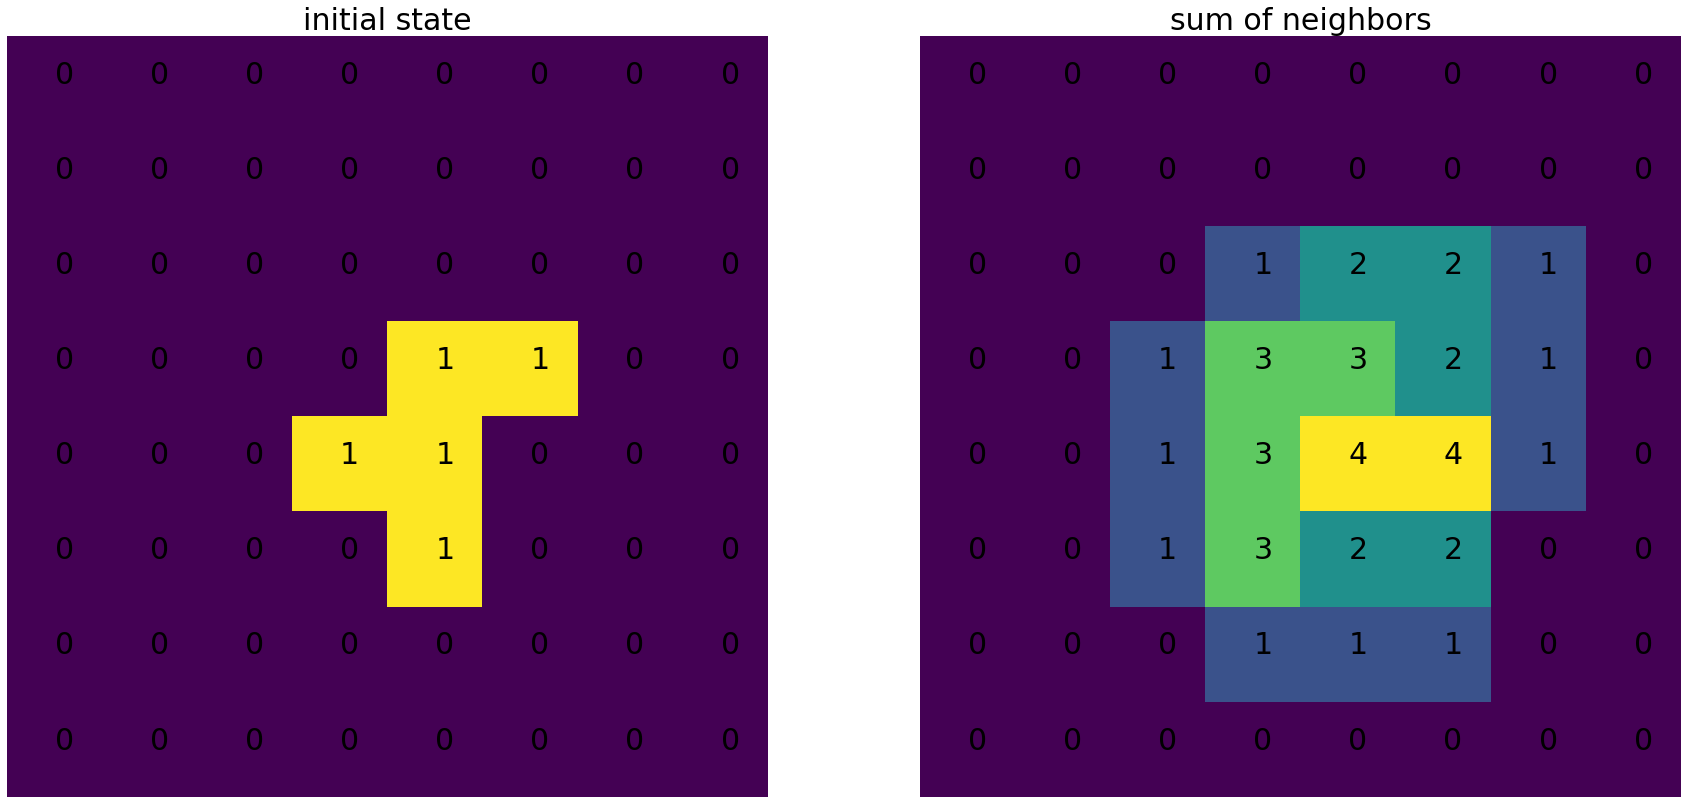

In [3]:
def NN_roll(Z,M):
    
    D = np.zeros(np.shape(Z))
    D+= np.roll(Z, -1, axis = 1)
    D+=np.roll(Z, 1, axis = 1)
    D+=np.roll(Z, -1, axis = 0)
    D+= np.roll(Z, 1, axis = 0)
    D+=np.roll(np.roll(Z, -1, axis = 0), -1, axis = 1)
    D+=np.roll(np.roll(Z, 1, axis = 0), -1, axis = 1)
    D+=np.roll(np.roll(Z, 1, axis = 0), 1, axis = 1)
    D+=np.roll(np.roll(Z, -1, axis = 0), 1, axis = 1)
    
    return D

mat = emb_mat(grower,8)
NN_mat = NN_roll(mat,1)

plt.rcParams["figure.figsize"] = (30,30)

fig ,ax = plt.subplots(1,2)
ax[0].imshow(mat)
ax[1].imshow(NN_mat)
for i in range(8):
    for j in range(8):
        ax[0].text(i,j,str(int(mat[j,i])),fontsize=30)
        ax[0].axis('off')
        ax[0].set_title('initial state',fontsize=30)
        
        ax[1].text(i,j,str(int(NN_mat[j,i])),fontsize=30)
        ax[1].axis('off')
        ax[1].set_title('sum of neighbors',fontsize=30)


Now that we know the number of neighbors of each cell we need to apply the rules to successively calculate the proceeding states. Since the rules depend only on the number of neighbors, which is an integer between 0 and 8, any b map f:{0,..,8} ->{0,1,2} where o,1,2 stand respectively for die, live or do nothing. Game of Life would be a particular choice of map we use. We can therefore experiment with different rules. Below are two functions. The function rule applies a given rule to a state after counting its neighbors. The function game_of_life runs the algorithm for a given number steps and returns a 3d array of the consecutive 2d slices. and animate produces any animation of it.

In [4]:
#nn      = np.array([0,1,2,3,4,5,6,7,8]) # the number of neighbors get mapped to an action
#actions = np.array([0,0,2,1,0,0,0,0,0]) 


def rule(Z,nn,actions,f,*args):
    D =f(Z,*args)
    for k,v in zip(actions,nn):
        if k != 2:
            Z[D == v] = k
    return Z

def game_of_life(Z,steps,nn,actions,time_it,f,*args):
    d = len(Z)
    
    if time_it == False:
        arr=np.zeros((steps,d,d))


        arr[0,:,:] = Z

        t0 = time.time()
        for i in range(1,steps):
            arr[i,:,:]= rule((arr[i-1,:,:]),nn,actions,f,*args) 
            if i %int(steps/5) == 0:
                print('step', i)
            i = i + 1
        t = time.time()-t0    
        print('this took:',str(int(t*1e4)/1e4) ,'seconds for',str(steps),'steps')
        return arr
    else:
        t0 = time.time()
        for i in range(1,steps):
            Z= rule(Z,nn,actions,f,*args) 
        t = time.time()-t0 
        print('this took:',str(int(t*1e4)/1e4) ,'seconds for',str(steps),'steps')
        
        
    

def animate(arr,steps):  
    fig,ax = plt.subplots(figsize=(10,10))
    ims=[]
    plt.rcParams["figure.figsize"] = (30,30)
    for i in range(steps):
        im = ax.imshow(arr[i],animated = True)
        ims.append([im])
    return animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)

below are all the relevant parameters to produce a single run. As they are they should produce an animation that runs reasonably well, but you can play around with them. You can pick from the three initial conditions defined earlier or write your own.

In [5]:
# uncomment to run diffrent initial state

init = grower
#init = periodic
#init = floater

nn      = np.array([0,1,2,3,4,5,6,7,8]) 
actions = np.array([0,0,2,1,0,0,0,0,0])
steps =500        #number of steps
d =128            # dimentions of field

    



In [6]:
X = emb_mat(init,d)
arr = game_of_life(X,steps,nn,actions,False,NN_roll,1)

step 100
step 200
step 300
step 400
this took: 0.1639 seconds for 500 steps


RuntimeError: Requested MovieWriter (ffmpeg) not available

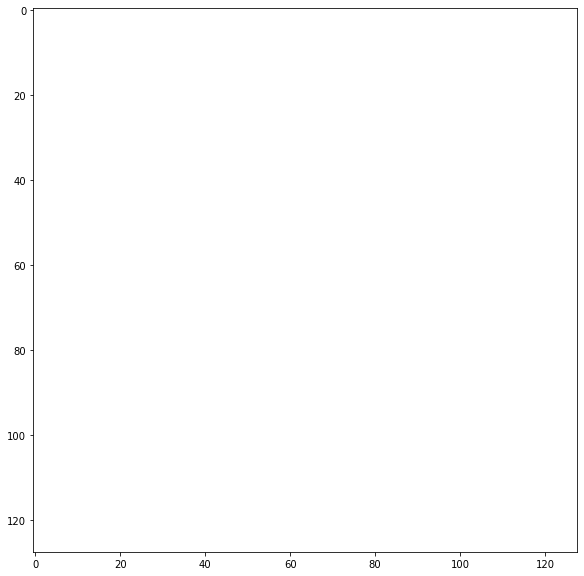

In [7]:
# this will take a few seconds
HTML(animate(arr,200).to_html5_video())

An alternative way to arrive at the number of neighbors would be to treat the input array as a network and use ist adjacency matrix. In graph theory the adjacency matrix has 1 at i,j if the respective nodes are connected and 0 otherwise. By rolling out our input field into a vector, we can calculate the number of 'active' neighbors by simply taking the dot product with the adjacency matrix. Since the rolled out state vector already has d * d entries the adjacency matrix now has d⁴ eniers. Since most of these are zeros and the adjacency matrix is both diagonal and symmetric we can use a sparse data type from scipy to store it.


In [10]:
# this function sets up an adjecancy matrix
def adj_mat(d):
    
    m1= np.zeros(d**2)
    m1[1],m1[-1] = 1,1
    m1[d]=1
    m1[-d]=1
    m1[1+d]=1
    m1[-1+d]=1
    m1[1-d]=1
    m1[-1-d]=1
    ofs1 = np.arange(d**2)[m1==1]
    ofs = np.zeros(len(ofs1)*2)
    ofs[:len(ofs1)]= ofs1
    ofs[len(ofs1):]=-ofs1
    
    data = np.expand_dims(np.ones(d**2),0).repeat(len(ofs), axis=0)
    return dia_matrix((data, ofs), shape=(d**2, d**2))


#this function finds the number of nearst neighbours using the adj_mat
def NN_adj(c,adj):
    l=len(c)
    c_=c.reshape(c.size)
    return adj.dot(c_).reshape((l,l))


Text(0.5, 1.0, 'adjeceancy matrix for nearest neighbor')

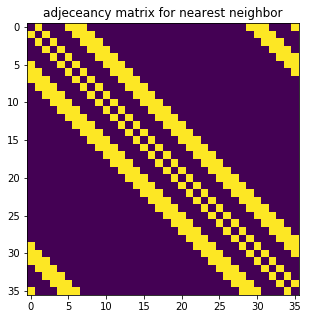

In [11]:
adj = adj_mat(6).toarray()
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(adj)
plt.title('adjeceancy matrix for nearest neighbor')

In [12]:
adj = adj_mat(d)
game_of_life(X,10000,nn,actions,1,NN_roll,1)
game_of_life(X,10000,nn,actions,1,NN_adj,adj)


this took: 4.4097 seconds for 10000 steps
this took: 2.2331 seconds for 10000 steps


What we are doing is essentially a convolution. We are multiplying the field with the mask shown below centered once at each point and adding them all up. 

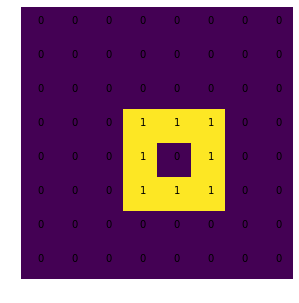

In [13]:
def Mask(d):
    msk = np.zeros((d,d))
    d2 = int(d/2)
    x = np.array([[1,1,1],[1,0,1],[1,1,1]])
    msk[d2-1:d2+2,d2-1:d2+2]=x
    return msk

Msk = Mask(8)

plt.rcParams["figure.figsize"] = (5,5)

fig ,ax = plt.subplots()
ax.imshow(Msk)
for i in range(8):
    for j in range(8):
        ax.text(i,j,str(int(Msk[j,i])),fontsize=10)
        ax.axis('off')
        #ax.set_title('initial state',fontsize=5)

Convolution theory states that a convolution in fourier space is simply a multiplication. We therefore Fourier transform both mask and game state, multiply them and transform them back. Now this obviously adds the computations needed to transform back and forth. It's therefore not clear whether it will perform better or worse. We perform the fourier transform on the mask only once to save time.

In [14]:

Msk_ = np.roll(Mask(d),int(d/2),0)
Msk_ = np.roll(Msk_,int(d/2),1)
Msk_ = np.fft.fft2(Msk_)

def NN_conv(Z,Msk_):
    Z_ = np.fft.fft2(Z)
    
    nn_ = np.fft.ifft2(Z_*Msk_)
    
    return np.round(nn_.real)


We finally compare all three methods. 

In [15]:
#adj = MM(d)
print('rolling method')
arr = game_of_life(X,10000,nn,actions,1,NN_roll,1)
print('using adjecancy matrix')
arr = game_of_life(X,10000,nn,actions,1,NN_adj,adj)
print('using convolution')
arr = game_of_life(X,10000,nn,actions,1,NN_conv,Msk_)


rolling method
this took: 5.2335 seconds for 10000 steps
using adjecancy matrix
this took: 2.3105 seconds for 10000 steps
using convolution
this took: 8.0437 seconds for 10000 steps


The adjacency matrix method is clearly the most effecient. It worth noting that all three methods can be used for other applications as well. 

I also have a brute force c++ implimentation which is alot faster than any